In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm


import sys

sys.path.append("../utils")
from utils import *

In [239]:
combined_df = retrieve_data()
combined_df

,Date,ROG_Last_Price,ROG_IVOL,CFR_Last_Price,CFR_IVOL,ZURN_Last_Price,ZURN_IVOL,Risk_Free_Rate
0,2023-10-25,237.55,17.6858,107.00,33.0793,426.4,15.7900,1.4594
1,2023-10-26,237.25,17.9504,104.45,33.5406,426.8,15.9736,1.4508
2,2023-10-27,237.75,19.6028,104.40,33.4355,424.4,16.3945,1.4478
3,2023-10-30,241.30,19.3503,104.75,33.1531,428.2,15.9477,1.4623
4,2023-10-31,233.85,19.2518,106.90,32.7788,430.6,15.7948,1.4489
...,...,...,...,...,...,...,...,...
248,2024-10-21,272.90,17.7575,126.65,31.1486,526.2,14.1699,0.6532
249,2024-10-22,272.20,18.2963,126.95,30.9890,520.4,14.7228,0.6544
250,2024-10-23,277.20,17.6974,126.05,31.3139,519.6,14.0134,0.6448
251,2024-10-24,279.80,17.7883,128.45,31.6005,520.6,14.4540,0.6213


In [240]:
combined_df = retrieve_data()
np.random.seed(42)
n_days = 252
dt = 1 / n_days
close = combined_df[["ROG_Last_Price", "CFR_Last_Price", "ZURN_Last_Price"]]
tickers = close.columns
log_returns = np.log((close / close.shift(1)).dropna())

# Heston Stochastic Volatility Model 

only use constant interest rate r + does not incorporate option prices into the calibration process.

!!! calibrate based solely on historical stock price data, particularly the realized volatility of returns.

options data need to be collect more on daily basis from 2024/25/07 to 024/25/10.
i only collected on quaterly basis so now cannot right

In [241]:
vol = log_returns.rolling(window=30).var() * n_days
vol

,ROG_Last_Price,CFR_Last_Price,ZURN_Last_Price
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
...,...,...,...
248,0.020141,0.118830,0.008371
249,0.019935,0.118104,0.009412
250,0.022582,0.118542,0.009246
251,0.018368,0.120691,0.009082


In [242]:
vol.mean()

ROG_Last_Price     0.040053
CFR_Last_Price     0.080205
ZURN_Last_Price    0.019759
dtype: float64

In [243]:
vol.iloc[0]

ROG_Last_Price    NaN
CFR_Last_Price    NaN
ZURN_Last_Price   NaN
Name: 1, dtype: float64

In [244]:
def objective(x):
    a = x**2 - 1
    return a

In [245]:
bounds = [
    (0.1, 10.0),  # kappa
    (0.001, 0.5),  # theta
    (0.01, 1.0),  # sigma
    (-0.99, 0.99),
]  # rho

result = minimize(objective, x0=[100], bounds=[(-np.inf, np.inf)], method="L-BFGS-B")

In [246]:
result

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -1.0
        x: [-2.149e-09]
      nit: 3
      jac: [ 1.110e-08]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [247]:
sys.path.append("./linh")
from option import *

In [248]:
import os

In [249]:
files = ["rog_call.csv", "cfr_call.csv", "zurn_call.csv"]

In [250]:
input_directory = "../data/option_data/"

In [251]:
options = pd.DataFrame(
    columns=["maturity", "strike", "price", "IV", "day", "month", "year", "product"]
)
for i, f in enumerate(files):
    for file in next(os.walk(input_directory + "cleaned"))[1]:
        data = pd.read_csv(f"../data/option_data/cleaned/{file}/" + f)
        data["day"] = file[:2]
        data["month"] = file[2:4]
        data["year"] = file[4:]
        data["product"] = tickers[i]
        options = pd.concat([options, data])

/tmp/ipykernel_2784/335833525.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  options = pd.concat([options, data])


In [252]:
options = options.sort_values(["product", "month", "day", "maturity"])

In [253]:
options

,maturity,strike,price,IV,day,month,year,product
0,0.156057,124,9.674999,24.402237,25,07,2024,CFR_Last_Price
1,0.156057,126,8.200000,23.955641,25,07,2024,CFR_Last_Price
2,0.156057,128,6.850000,23.466326,25,07,2024,CFR_Last_Price
3,0.156057,130,5.600000,22.889894,25,07,2024,CFR_Last_Price
4,0.156057,132,4.515000,22.497936,25,07,2024,CFR_Last_Price
...,...,...,...,...,...,...,...,...
49,0.229979,520,13.550000,14.122618,25,10,2024,ZURN_Last_Price
50,0.229979,540,5.600000,13.379794,25,10,2024,ZURN_Last_Price
51,0.229979,560,1.720000,12.748696,25,10,2024,ZURN_Last_Price
52,0.229979,580,1.505000,16.218067,25,10,2024,ZURN_Last_Price


In [254]:
from lmfit import Parameters, minimize

In [255]:
options[options["product"] == "CFR_Last_Price"]

,maturity,strike,price,IV,day,month,year,product
0,0.156057,124,9.674999,24.402237,25,07,2024,CFR_Last_Price
1,0.156057,126,8.200000,23.955641,25,07,2024,CFR_Last_Price
2,0.156057,128,6.850000,23.466326,25,07,2024,CFR_Last_Price
3,0.156057,130,5.600000,22.889894,25,07,2024,CFR_Last_Price
4,0.156057,132,4.515000,22.497936,25,07,2024,CFR_Last_Price
...,...,...,...,...,...,...,...,...
43,0.229979,130,7.125000,30.834446,25,10,2024,CFR_Last_Price
44,0.229979,135,5.060000,30.493761,25,10,2024,CFR_Last_Price
45,0.229979,140,3.480000,30.214775,25,10,2024,CFR_Last_Price
46,0.229979,145,2.350000,30.146441,25,10,2024,CFR_Last_Price


In [256]:
combined_df.iloc[0]["Date"].strftime("%Y-%m-%d")

'2023-10-25'

In [323]:
import numpy as np
import pandas as pd
from tqdm import tqdm


class HestonModelCalibration:
    def __init__(self, current_id, data, n_days=252):
        self.current_id = current_id
        self.data = data
        self.n_days = n_days
        self.dt = 1 / n_days
        self.tickers = data.columns
        self.log_returns = np.log((data / data.shift(1)).dropna())

    def calculate_realized_vol(self, window_size=30):
        """Calculate realized volatility for initial variance"""
        return self.log_returns.rolling(window=window_size).var() * self.n_days

    def estimate_correlation_matrix(self, window_size=30):
        """Estimate correlation matrix from historical data"""
        return self.log_returns.iloc[-window_size:].corr().values

    def func_heston(
        self,
        u,
        St,
        K,
        r,
        T,
        sigma,
        kappa,
        theta,
        v0,
        rho,
    ):

        # logger_yq.info(f"Final result: {result}")
        # b1 = kappa + lambda_ - rho * sigma * r
        # b2 = kappa + lambda_
        # prod = rho * sigma * 1j * u
        # d1 = np.sqrt((prod - b1)**2 - sigma ** 2 * (1j * r - (1j)**2))
        # d2 = np.sqrt((prod - b2)**2 + sigma ** 2 * (1j * r - (1j)**2))
        # g1 = (b1 - prod + d1) / (b1 - prod - d1)
        # g2 = (b2 - prod + d2) / (b2 - prod - d2)

        # c1 = r * 1j * u * T + kappa * theta / (sigma ** 2) * (b1 - prod + d1) * T - 2 * np.log((1 - g1 * np.exp(d1 * T)) / (1 - g1))
        # c2 = r * 1j * u * T + kappa * theta / (sigma ** 2) * (b2 - prod + d2) * T - 2 * np.log((1 - g2 * np.exp(d2 * T)) / (1 - g2))

        # d1 = (b1 - prod + d1) / (sigma ** 2) * (1 - g1 * np.exp(d1 * T)) / (1 - g1)
        # d2 = (b2 - prod + d2) / (sigma ** 2) * (1 - g2 * np.exp(d2 * T)) / (1 - g2)

        # res1 = St ** (u * 1j) * np.exp(c1 + d1 * v0)
        # res2 = St ** (u * 1j) * np.exp(c2 + d2 * v0)

        ## ASSUME LAMBDA IS 0
        xi = kappa - rho * sigma * 1j * u
        d = np.sqrt((rho * sigma * 1j * u - xi) ** 2 - sigma**2 * (-u * 1j - u**2))
        g = (xi - rho * sigma * 1j * u - d) / (xi - rho * sigma * 1j * u + d)
        C = r * 1j * u * T + (kappa * theta) / sigma**2 * (
            (xi - rho * sigma * 1j * u - d) * T
            - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g))
        )
        D = (
            (xi - rho * sigma * 1j * u - d)
            / sigma**2
            * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
        )
        return np.exp(C + D * v0 + 1j * u * np.log(St)).fillna(0)

    def price_heston_mid(self, St, K, r, T, sigma, kappa, theta, v0, rho):

        from scipy.integrate import quad_vec

        res1 = lambda u: np.real(
            np.exp(-1j * u * np.log(K))
            / (1j * u)
            * self.func_heston(u - 1j, St, K, r, T, sigma, kappa, theta, v0, rho)
        )
        # res2 = lambda u: np.real(np.exp(-1j * u * np.log(K)) / (1j * u) * self.func_heston(u, St, K, r, T, sigma, kappa, theta, v0, rho)[1])

        integral1, _ = quad_vec(res1, 0, 1000)
        # integral2, _ = quad_vec(res2, 0, np.inf)
        # C = St * (1/2 + 1/np.pi * integral1) - K * np.exp(-r * T) * (1/2 + 1/np.pi * integral2)
        # C = C.fillna(0)

        C = np.exp(-r * T) * 0.5 * St - np.exp(-r * T) / np.pi * integral1
        return C

    def calibrate_heston_parameters(self, window_size=30):
        """
        Calibrate Heston model parameters using historical data
        Returns dict with parameters for each asset
        """
        model_params = {}
        mse = {}
        for i, ticker in enumerate(self.tickers):
            # Initial estimates based on historical data
            # vol = self.calculate_realized_vol()[ticker].dropna()

            # def objective(x):
            #     kappa, theta, sigma, rho = x
            #     var_pred = theta + (vol.iloc[0] - theta) * np.exp(-kappa * np.arange(len(vol)) * self.dt)
            #     # ko tune cho sigma rho
            #     return np.mean((var_pred - vol)**2)
            # # variance_paths[k, i, j] = (v_prev +
            # #             kappa[k] * (theta[k] - v_prev) * dt +
            # #             sigma[k] * np.sqrt(v_prev * dt) * dw_s[k * 2 + 1, j] * chol_corr[k * 2 + 1][k * 2 + 1])
            # bounds = [(0.1, 10.0),  # kappa
            #          (0.001, 0.5),  # theta
            #          (0.01, 1.0),   # sigma
            #          (-0.99, 0.99)] # rho
            option_date = (
                options["year"].astype(str)
                + "-"
                + options["month"].astype(str)
                + "-"
                + options["day"].astype(str)
            )
            date = combined_df.iloc[self.current_id]["Date"].strftime("%Y-%m-%d")
            volatility_surface = options[
                (options["product"] == ticker) & (option_date == date)
            ]
            maturities = volatility_surface["maturity"].astype("float")
            strikes = volatility_surface["strike"].astype("float")
            price = volatility_surface["price"].astype("float")
            rates = 0.01107

            params = Parameters()
            params.add("kappa", value=0.1, min=0.001, max=10)
            params.add("theta", value=0.1, min=0.001, max=0.1)
            params.add("v0", value=0.1, min=0.001, max=0.1)
            params.add("rho", value=0.1, min=-1, max=1.0)
            params.add("sigma", value=0.1, min=0.001, max=0.1)

            objective = lambda paramVect: (
                price
                - self.price_heston_mid(
                    self.data.iloc[self.current_id][ticker],
                    strikes,
                    rates,
                    maturities,
                    paramVect["sigma"].value,
                    paramVect["kappa"].value,
                    paramVect["theta"].value,
                    paramVect["v0"].value,
                    paramVect["rho"].value,
                )
            ) / (price + 1e-8)

            result = minimize(
                objective,
                params,
                method="leastsq",
                max_nfev=15,
                ftol=1e-4,
                xtol=1e-4,
                gtol=1e-4,
            )
            dicts = result.params.valuesdict()
            model_params[ticker] = {
                "kappa": dicts["kappa"],
                "theta": dicts["theta"],
                "sigma": dicts["sigma"],
                "rho": dicts["rho"],
                "v0": dicts["v0"],
            }
            mse[ticker] = result.residual
        return model_params, mse


def MultivariateHestonSimulation(
    s0,
    tickers,
    dt,
    calibrated_params,
    correlation_matrix,
    n_paths=1000,
    last_id=287,
    current_id=187,
    window_size=30,
    variance_reduction="av",
    scheme="euler",
    r=0.01,
):

    if variance_reduction not in ["av", None]:
        raise ValueError("Supported variance reduction method is av")
    if scheme not in ["euler", "qe"]:
        raise ValueError("Supported discretization schemes are 'euler' and 'qe'")
    n_assets = len(tickers)
    T = dt * (last_id - current_id)
    n_steps = int(T / dt)

    # Initialize arrays
    result = np.zeros((n_assets, n_paths, n_steps))
    variance_paths = np.zeros((n_assets, n_paths, n_steps))

    # Extract parameters for each asset
    kappa = np.array([calibrated_params[t]["kappa"] for t in tickers])
    theta = np.array([calibrated_params[t]["theta"] for t in tickers])
    sigma = np.array([calibrated_params[t]["sigma"] for t in tickers])
    rho = np.array([calibrated_params[t]["rho"] for t in tickers])

    # Get initial variances
    v0 = {t: calibrated_params[t]["v0"] for t in tickers}
    # Ensure correlation matrix is 2D numpy array
    if isinstance(correlation_matrix, pd.DataFrame):
        correlation_matrix = correlation_matrix.values

    # Cholesky decomposition for correlated Brownian motions

    # s1 s2 s3
    #     s1  1  s1s2 s1s3
    #     s2 s1s2 1  s2s3
    #     s3

    #     correlation matrix 6x6 (only si-sj and si-vi non-zero)
    #     s1          v1          s2          v2          s3          v3
    # s1   1          rho_s1v1    rho_s1s2    0           rho_s1s3    0
    # v1   rho_s1v1   1           rho_s2v1
    # s2   rho_s1s2   rho_s2v1    1
    # v2   0
    # s3   rho_s1s3
    # v3   0

    # ==> simulate s1, s2, s3, v1, v2, v3 with 6 different z
    r1, r2, r3 = rho[0], rho[1], rho[2]
    r12 = correlation_matrix[0][1]
    r23 = correlation_matrix[1][2]
    r13 = correlation_matrix[0][2]
    correlation_matrix = np.array(
        [
            [1, r1, r12, r2 * r12, r13, r3 * r13],
            [r1, 1, r1 * r12, r1 * r2 * r12, r1 * r13, r1 * r3 * r13],
            [r12, r1 * r12, 1, r2, r23, r3 * r23],
            [r2 * r12, r1 * r2 * r12, r2, 1, r2 * r23, r2 * r3 * r23],
            [r13, r1 * r13, r23, r2 * r23, 1, r3],
            [r3 * r13, r1 * r3 * r13, r2 * r23, r2 * r3 * r23, r3, 1],
        ]
    )

    try:
        chol_corr = np.linalg.cholesky(correlation_matrix)
    except np.linalg.LinAlgError:
        # If matrix is not positive definite, adjust it
        correlation_matrix = (
            correlation_matrix + correlation_matrix.T
        ) / 2  # Ensure symmetry
        min_eig = np.min(np.real(np.linalg.eigvals(correlation_matrix)))
        if min_eig < 0:
            correlation_matrix -= min_eig * np.eye(
                correlation_matrix.shape[0]
            )  # Shift eigenvalues if needed
        try:
            # Try Cholesky again on the adjusted matrix
            chol_corr = np.linalg.cholesky(correlation_matrix)
        except np.linalg.LinAlgError:
            # If still not positive definite, add a small identity matrix (regularization)
            epsilon = 1e-8
            correlation_matrix += epsilon * np.eye(correlation_matrix.shape[0])
            chol_corr = np.linalg.cholesky(correlation_matrix)

    if (
        scheme == "qe"
    ):  # using the qe scheme, we have to apply correlation correction to our correlation matrix
        q = np.zeros((n_assets * 2, n_assets * 2))
        for i in range(n_assets):
            q[i * 2][i * 2] = np.sqrt(1 - rho[i] ** 2)
            q[i * 2][i * 2 + 1] = rho[i] ** 2
            q[i * 2 + 1][i * 2 + 1] = 1

        q_inverse = np.linalg.inv(q)
        chol_corr = np.matmul(q_inverse, chol_corr)

    paths_to_simulate = n_paths // 2 if variance_reduction == "av" else n_paths

    dw = np.random.normal(size=(n_assets * 2, paths_to_simulate, n_steps))

    for p in range(paths_to_simulate):
        dw[:, p, :] = np.matmul(
            chol_corr, dw[:, p, :]
        )  # need to check if it is correct
    # otherwise can just multiply it by in the for loop
    # something like: np.matmul(chol_corr, dw[:, :, j])
    # Correlate price and variance Brownian motion
    for j in range(n_steps):
        for k in range(n_assets):
            if j == 0:
                result[k, :paths_to_simulate, j] = s0[tickers[k]]
                variance_paths[k, :, j] = v0[tickers[k]]

                if variance_reduction == "av":
                    result[k, paths_to_simulate:, j] = s0[tickers[k]]
                    variance_paths[k, paths_to_simulate:, j] = v0[tickers[k]]
            else:
                if scheme == "euler":
                    v_prev = np.maximum(variance_paths[k, :paths_to_simulate, j - 1], 0)
                    # Update variance
                    result[k, :paths_to_simulate, j] = result[
                        k, :paths_to_simulate, j - 1
                    ] * np.exp(
                        (r - 0.5 * v_prev) * dt + np.sqrt(v_prev * dt) * dw[k * 2, :, j]
                    )

                    variance_paths[k, :paths_to_simulate, j] = (
                        v_prev
                        + kappa[k] * (theta[k] - v_prev) * dt
                        + sigma[k] * np.sqrt(v_prev * dt) * dw[k * 2 + 1, :, j]
                    )

                    # Update price

                    if variance_reduction == "av":
                        result[k, paths_to_simulate:, j] = result[
                            k, paths_to_simulate:, j - 1
                        ] * np.exp(
                            (r - 0.5 * v_prev) * dt
                            + np.sqrt(v_prev * dt) * (-dw[k * 2, :, j])
                        )

                        variance_paths[k, paths_to_simulate:, j] = (
                            v_prev
                            + kappa[k] * (theta[k] - v_prev) * dt
                            + sigma[k] * np.sqrt(v_prev * dt) * (-dw[k * 2 + 1, :, j])
                        )

                if scheme == "qe":
                    # m = theta
                    # sigma = sigma
                    # kappa = kappa
                    v_prev = np.maximum(variance_paths[k, :paths_to_simulate, j - 1], 0)
                    e_v = theta[k] + (v_prev - theta[k]) * np.exp(-kappa[k] * dt)
                    var_v = (
                        v_prev
                        * sigma[k] ** 2
                        * np.exp(-kappa[k] * dt)
                        / kappa[k]
                        * (1 - np.exp(-kappa[k] * dt))
                        + theta[k]
                        * sigma[k] ** 2
                        / (2 * kappa[k])
                        * (1 - np.exp(-kappa[k] * dt)) ** 2
                    )

                    trident = var_v / (e_v**2)
                    mask_less = (trident <= 1.5).astype(
                        "int"
                    )  ## LEVEL CAN BE SET [1, 2]
                    b = 2 / trident - 1 + np.sqrt(2 / trident * (2 / trident - 1))
                    a = theta[k] / (1 + b)
                    p = (trident - 1) / (trident + 1)
                    beta = (1 - p) / theta[k]
                    U = norm.cdf(dw[k * 2 + 1, :, j])
                    mask_pu = ((p < U) & (U < 1)).astype("int")
                    variance_paths[k, :paths_to_simulate, j] = a * (
                        (np.sqrt(b) + dw[k * 2 + 1, :, j]) ** 2
                    ) * mask_less + 1 / beta * np.log((1 - p) / (1 - U)) * mask_pu * (
                        1 - mask_less
                    )

                    k0 = -rho[k] * kappa[k] * theta[k] * dt / sigma[k]

                    sigma1 = sigma2 = (
                        0.5  # ARBITRARY SETTING, MORE SOPHISTICATED WOULD BE BASED ON MOMENT-MATCHING
                    )
                    k1 = (
                        sigma1 * dt * (kappa[k] * rho[k] / sigma[k] - 0.5)
                        - rho[k] / sigma[k]
                    )
                    k2 = (
                        sigma2 * dt * (kappa[k] * rho[k] / sigma[k]) + rho[k] / sigma[k]
                    )
                    k3 = sigma1 * dt * (1 - rho[k] ** 2)
                    k4 = sigma2 * dt * (1 - rho[k] ** 2)
                    result[k, :paths_to_simulate, j] = (
                        result[k, :paths_to_simulate, j - 1]
                        * np.exp(k0 + r - k1 * v_prev)
                        * np.exp(
                            k2 * variance_paths[k, :paths_to_simulate, j]
                            + np.sqrt(
                                k3 * v_prev
                                + k4 * variance_paths[k, :paths_to_simulate, j]
                            )
                            * dw[k * 2, :, j]
                        )
                    )

                    if variance_reduction == "av":
                        U = norm.cdf(-dw[k * 2 + 1, :, j])
                        mask_pu = ((p < U) & (U < 1)).astype("int")

                        variance_paths[k, paths_to_simulate:, j] = a * (
                            (np.sqrt(b) + (-dw[k * 2 + 1, :, j])) ** 2
                        ) * mask_less + 1 / beta * np.log(
                            (1 - p) / (1 - U)
                        ) * mask_pu * (
                            1 - mask_less
                        )
                        result[k, paths_to_simulate:, j] = (
                            result[k, paths_to_simulate:, j - 1]
                            * np.exp(k0 + r - k1 * v_prev)
                            * np.exp(
                                k2 * variance_paths[k, paths_to_simulate:, j]
                                + np.sqrt(
                                    k3 * v_prev
                                    + k4 * variance_paths[k, paths_to_simulate:, j]
                                )
                                * (-dw[k * 2, :, j])
                            )
                        )

    if variance_reduction == "emc":
        for k in range(n_assets):
            correction_factor = result[k][-1, :].mean() / result[k][-1, :]
            result[k] = result[k] * correction_factor

    return result, tickers, variance_paths


def run_heston_backtest(combined_df, backtest_start, backtest_end, last_id, params):
    # Initialize model and calibrate parameters
    close = combined_df[["ROG_Last_Price", "CFR_Last_Price", "ZURN_Last_Price"]]

    prices = []
    prices_var = []
    calibrate_results = []
    for current_id in tqdm(range(backtest_start, backtest_end)):
        # Get data for current window
        window_data = close.iloc[max(0, current_id - 30) : current_id]
        heston_calibration = HestonModelCalibration(current_id, close)
        calibrated_params, calibrate_res = (
            heston_calibration.calibrate_heston_parameters(window_size=30)
        )
        calibrate_results.append(calibrate_res)
        correlation_matrix = heston_calibration.estimate_correlation_matrix(
            window_size=30
        )

        payoff = []
        result, _, variance_paths = MultivariateHestonSimulation(
            s0=close.iloc[current_id],
            tickers=close.columns,
            calibrated_params=calibrated_params,
            correlation_matrix=correlation_matrix,
            current_id=current_id,
            last_id=last_id,
            **params,
        )

        # Construct paths and calculate payoffs
        old_path_rog = combined_df["ROG_Last_Price"].iloc[:current_id]
        old_path_cfr = combined_df["CFR_Last_Price"].iloc[:current_id]
        old_path_zurn = combined_df["ZURN_Last_Price"].iloc[:current_id]

        path_rog = []
        path_cfr = []
        path_zurn = []
        for i in range(result.shape[-2]):
            path_rog.append(np.append(old_path_rog, result[0][i].flatten()))
            path_cfr.append(np.append(old_path_cfr, result[1][i].flatten()))
            path_zurn.append(np.append(old_path_zurn, result[2][i].flatten()))
        payoff = payoff_func_parallel(
            path_rog,
            path_cfr,
            path_zurn,
            combined_df.iloc[current_id]["Date"],
            risk_free=0.01107,
            risk_neutral=True,
            verbose=False,
        )
        prices.append(np.mean(payoff))
        prices_var.append(np.mean(payoff))

        print(prices)
    return prices, prices_var, calibrate_results

In [324]:
# import matplotlib.pyplot as plt

# def evaluation_plot(backtest_start, backtest_end, combined_df, prices):
#     # Load and process actual price data
#     real_price = pd.read_csv('../data/product_price_full.csv')
#     real_price['Date'] = pd.to_datetime(real_price['Date'], dayfirst=True)
#     real_price = real_price.sort_values(by='Date', ascending=True)
#     real_price['Product'] = 1000 * real_price['Product']

#     # Filter actual prices for the backtest period
#     actual = real_price[(real_price['Date'] >= combined_df.iloc[backtest_start]['Date']) &
#                         (real_price['Date'] <= combined_df.iloc[backtest_end - 1]['Date'])]['Product'].values
#     dates = real_price[(real_price['Date'] >= combined_df.iloc[backtest_start]['Date']) &
#                        (real_price['Date'] <= combined_df.iloc[backtest_end - 1]['Date'])]['Date']

#     # Ensure `prices` has the same length as `dates`
#     if len(prices) != len(dates):
#         prices = np.mean(prices, axis=0) if prices.ndim > 1 else np.repeat(prices, len(dates))

#     # Plotting
#     plt.figure(figsize=(20, 4))
#     plt.plot(dates, prices, marker='o', label='Predicted Prices')
#     plt.plot(dates, actual, marker='o', label='Actual Prices')
#     plt.title('Price Comparison Over Time')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.ylim(850, 1150)
#     plt.legend()
#     plt.show()

In [325]:
params = {
    "dt": 1 / 252,
    "n_paths": 10000,
    "variance_reduction": "av",  # None, 'av', 'emc'
    "scheme": "qe",
}  # 'qe', 'euler'

In [326]:
for t in tickers:
    print(t)

ROG_Last_Price
CFR_Last_Price
ZURN_Last_Price


In [ ]:
# Initialize backtest parameters
last_id = 287
backtest_start = 187
backtest_end = 252

# Run backtest
prices, prices_var, calibrated_result = run_heston_backtest(
    combined_df, backtest_start, backtest_end, last_id, params
)

  0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
calibrated_params = {
    "ROG_Last_Price": {
        "kappa": 0.10001357790518331,
        "theta": 0.1,
        "sigma": 0.09999999999999999,
        "rho": 0.10000000000000009,
        "v0": 0.1,
    },
    "CFR_Last_Price": {
        "kappa": 0.10001357790518331,
        "theta": 0.1,
        "sigma": 0.09999999999999999,
        "rho": 0.10000000000000009,
        "v0": 0.1,
    },
    "ZURN_Last_Price": {
        "kappa": 0.10001357790518331,
        "theta": 0.1,
        "sigma": 0.09999999999999999,
        "rho": 0.10000000000000009,
        "v0": 0.1,
    },
}

In [ ]:
np.array([calibrated_params[t]["kappa"] for t in tickers])

array([0.10001358, 0.10001358, 0.10001358])

/home/bach/mh4518_simulation_in_fin/notebooks/../utils/utils.py:241: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  real_price['Date'] = pd.to_datetime(real_price['Date'], dayfirst=True)


1642.0183108048454


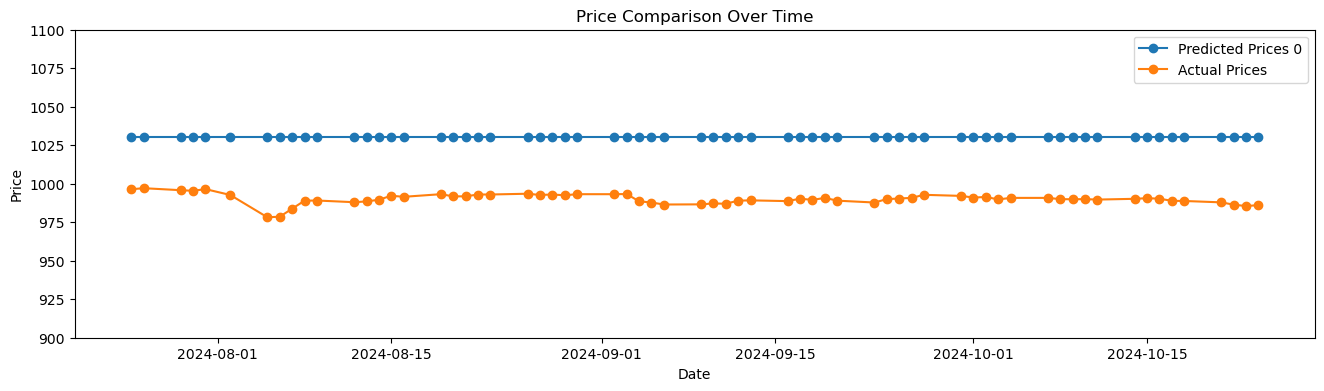

In [ ]:
evaluation_plot(
    backtest_start, backtest_end, combined_df, np.array(prices), ylim=(900, 1100)
)

In [ ]:
df.DataFrame(calibrated_result).mean()